#### Imports & Downloads

In [116]:
!pip install emoji
!pip install pyspellchecker
!pip install textblob
!pip install ftfy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 4.2 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 4.8 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 4.9 MB/s eta 0:00:03
     ------------ --------------------------- 3.9/12.8 MB 5.0 MB/s eta 0:00:02
     -------------- ------------------------- 4.7/12.8 MB 4.9 MB/s eta 0:00:02
     ------------------ --------------------- 6.0/12.8 MB 5.1 MB/s eta 0:00:02
     ---------------------- ----------------- 7.1/12.8 MB 5.0 MB/s eta 0:00:02
     ------------------------- -------------- 8.1/12.8 MB 5.1 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 4.8 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.8 MB 4.5 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 4.4 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import emoji
from nltk.corpus import stopwords, wordnet
import time
from pathlib import Path

from collections import Counter
from spellchecker import SpellChecker
import os

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer, PorterStemmer
from nltk.stem import WordNetLemmatizer
from ftfy import fix_encoding
import spacy

pd.set_option('display.max_colwidth', None)

In [105]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

### Einladen der Daten

#### Trainingsdaten

In [5]:
current_dir = os.getcwd()
csv_path_train = os.path.abspath(os.path.join(current_dir, '../../../data/twitter_hate-speech/train.csv'))
df_origin = pd.read_csv(csv_path_train, encoding='utf-8', index_col=0)

df_origin.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0,factsguide: society now #motivation


In [6]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


#### Testdaten

In [7]:
csv_path_test = os.path.abspath(os.path.join(current_dir, '../../../data/twitter_hate-speech/test.csv'))
df_origin_test = pd.read_csv(csv_path_test, encoding='utf-8', index_col=0)

df_origin_test.head()

,tweet
id,
31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [8]:
df_origin_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17197 entries, 31963 to 49159
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   17197 non-null  object
dtypes: object(1)
memory usage: 268.7+ KB


## 1. Datenexploration

### 1.1 Datenqualitätsüberprüfung generell

In [9]:
# Check for null values
df_origin.isna().sum()

# no null's

label    0
tweet    0
dtype: int64

In [10]:
# check for duplicates
print(df_origin.duplicated().sum())

2432


### 1.2 Text Qualität Checks

In [11]:
df_raw = df_origin.copy()

##### 1.2.1 Überprüfung von stopwords

In [12]:
# which words are actually stop words?
stop_words = set(stopwords.words('english'))

stop_words_list = list(stop_words)
print(stop_words_list)

["you'd", 'before', 'his', 'with', 'in', 'again', 'are', 'some', 'then', 'haven', 'll', 'their', 'had', 'its', 'aren', "shan't", 'about', 'hasn', 'you', 'him', 're', "isn't", 'up', 'for', 'she', 'be', 'being', 'himself', 'each', 'as', 'by', 'weren', 'they', 'such', 'don', 'herself', 'it', 'shan', 'just', 'our', 'or', 'mustn', 'those', 'wouldn', 'very', 'should', "didn't", 'if', 'above', "hasn't", 'down', 'when', 'at', 'through', 'couldn', 'was', 'from', 'same', 'these', 'he', 'them', 'after', "you're", 'that', 'itself', 't', "hadn't", 'this', 'now', 'doing', 'an', 'do', 's', "wouldn't", 'what', 'whom', 'both', 'while', 'did', "needn't", 'my', 'a', "mustn't", 'how', 'were', 'can', 'having', 'does', 'myself', 'has', 'will', 'nor', "wasn't", 'few', 'her', 'm', 'is', 'yourself', 'below', "you've", "should've", 'y', 'didn', 'during', 'no', 'me', 'been', 'which', 'all', 'there', "aren't", "she's", 'between', 'than', 'and', 'ma', 'only', 'am', "haven't", 'mightn', 'needn', 'once', 'o', 'so', 

In [13]:
# find stop words in tweet column
def find_stop_words(df):
    df['stopwords'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
    return df


df_raw = find_stop_words(df_raw)
df_raw[df_raw['stopwords'].notna()].head()

,label,tweet,stopwords
id,,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,10
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,5
3,0,bihday your majesty,1
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,5
5,0,factsguide: society now #motivation,1


##### 1.2.2 Überprüfung von HTML tags/ special characters

In [14]:
def find_hash_tags(df):
    df['hashtags'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    return df


df_raw = find_hash_tags(df_raw)
df_raw[df_raw['hashtags'] > 0].head()

,label,tweet,stopwords,hashtags
id,,,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,10,1
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,5,3
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,5,1
5,0,factsguide: society now #motivation,1,1
6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,6,1


##### 1.2.3 Überprüfung von Wörtern mit Großbuchstaben

In [15]:
def find_num_uppercase(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    return df


df_raw = find_num_uppercase(df_raw)
df_raw[df_raw['upper_case'] > 0].head()


,label,tweet,stopwords,hashtags,upper_case
id,,,,,
161,0,new selfie \Â¤.Â¤/ #guy #mato #chapones,0,3,1
555,0,come on #ee piss poor reception today Â£20 a month and struggle to get a signal in #buxton put more masts up or i'm switching #grumpy,9,3,1
1109,1,"@user all happy for Ã¨ #lbgt family,but what i don't get is the incessant but thin veiled against other gay minorities?",10,1,1
1715,0,over a year after leaving @user i received a demand for Â£12. should have told me when i left! #paidnow #fuckoffnevercomingbacktosky,11,2,1
2502,0,#bahrain #youth #protesters #clash with #riot #police and #armoured #vehicles #Ø§ÙØ¨Ø­Ø±ÙÙ #Ø§ÙÙÙÙØ¯Ø±Ø§Øª,2,10,1


##### 1.2.4 Überprüfung von HTML Tags im Text

In [16]:
def identify_html_tags(text):
    pattern = re.compile('<.*?>')
    tags = pattern.findall(text)
    tag_count = len(tags)
    return tag_count

In [17]:
def find_html_tags(df):
    df['html_tag_count'] = df['tweet'].apply(lambda x: identify_html_tags(x))
    return df


df_raw = find_html_tags(df_raw)
df_raw[df_raw['html_tag_count'] > 0]
# Conclusion: no html tags

,label,tweet,stopwords,hashtags,upper_case,html_tag_count
id,,,,,,


##### 1.2.5 Überprüfung von URL's im Text

In [18]:
def identify_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    urls = pattern.findall(text)
    tag_count = len(urls)
    return tag_count

In [19]:
def find_urls(df):
    df['url_count'] = df['tweet'].apply(identify_urls)
    return df


df_raw = find_urls(df_raw)
df_raw[df_raw['url_count'] > 0]

,label,tweet,stopwords,hashtags,upper_case,html_tag_count,url_count
id,,,,,,,
1112,0,#fly #and #better #with #us #buranus #www.flybcc.com #call #7/24 #airbroker #flightâ¦,0,11,0,0,1
6376,0,#isitthursdayyet? it's not? awwww... #criticalrole #critter,1,3,0,0,1
8085,0,couple having sex www.drunk singapore girl get fuck,1,0,0,0,1
8485,0,so glad my #workout includes smoke breaks...www.smokeweedeatbacon.com #weed #bacon #fitness #sex #health #marijuana #strength #living,2,9,0,0,1
8661,0,@user just run 10kms for @user @user #loveisall pour donner: www.alvarum/heloiseetlespremas,2,1,0,0,1
25746,0,@user sirrr getting new one wowwww... to see this plss take care of urself...love youððâ¤ï¸â¤ï¸â¤ï¸â¤ï¸,3,0,0,0,1


##### 1.2.6 Überprüfung von oft auftretenden Wörter im Text

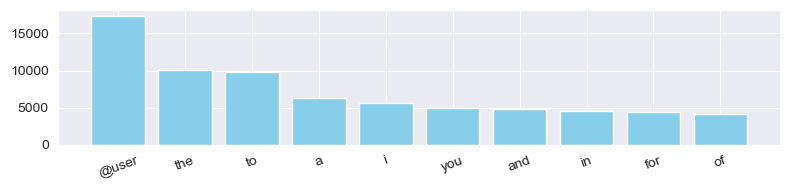

In [20]:
freq_words = pd.Series(' '.join(df_raw['tweet']).split()).value_counts()[:10]

words = freq_words.index
counts = freq_words.values
plt.figure(figsize=(8, 2))
plt.bar(words, counts, color='skyblue')

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


##### 1.2.7 Überprüfung von shortcuts/slangs im Text

In [21]:
shortcuts = {
    'ROFL': 'Rolling On The Floor Laughing',
    'STFU': 'Shut the f*** up',
    'ICYMI': 'In case you missed it',
    'TL;DR': 'Too long, didn’t read',
    'TMI': 'Too much information',
    'AFAIK': 'As Far As I Know',
    'LMK': 'Let me know',
    'NVM': 'Nevermind',
    'FTW': 'For the win',
    'BYOB': 'Bring your own beer',
    'BOGO': 'Buy one get one',
    'JK': 'Just kidding',
    'JW': 'Just wondering',
    'TGIF': 'Thank goodness it’s Friday',
    'TBH': 'To be honest',
    'TBF': 'To be frank',
    'RN': 'Right now',
    'FUBAR': 'F***** up beyond all recognition',
    'BRB': 'Be Right Back',
    'ISO': 'In search of',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'FTFY': 'Fixed that for you',
    'GG': 'Good Game',
    'BFD': 'Big freaking deal',
    'IRL': 'In Real Life',
    'DAE': 'Does anyone else?',
    'LOL': 'Laughing Out Loud',
    'SMH': 'Shaking My Head',
    'NGL': 'Not gonna lie',
    'BTS': 'Behind the scenes',
    'IKR': 'I Know Right',
    'TTYL': 'Talk to you later',
    'HMU': 'Hit me up',
    'FWIW': 'For what it’s worth',
    'IMO': 'In my opinion',
    'WYD': 'What are you doing?',
    'IMHO': 'In my humble opinion',
    'IDK': 'I Don’t Know',
    'IDC': 'I Don’t Care',
    'IDGAF': 'I don’t give a f***',
    'NBD': 'No big deal',
    'TBA': 'To be announced',
    'TBD': 'To be decided',
    'AFK': 'Away From Keyboard',
    'ABT': 'About',
    'IYKYK': 'If You Know You Know',
    'B4': 'Before',
    'BC': 'Because',
    'JIC': 'Just In Case',
    'FOMO': 'Fear Of Missing Out',
    'SNAFU': 'Situation Normal, All F***** Up',
    'GTG/G2G': 'Got To Go',
    'H8': 'Hate',
    'LMAO': 'Laughing My A** Off',
    'IYKWIM': 'If You Know What I Mean',
    'MYOB': 'Mind Your Own Business',
    'POV': 'Point Of View',
    'TLC': 'Tender Loving Care',
    'HBD': 'Happy Birthday',
    'W/E': 'Whatever',
    'WTF': 'What The F***',
    'WYSIWYG': 'What You See Is What You Get',
    'FWIF': 'For What It’s Worth',
    'TW': 'Trigger Warning',
    'EOD': 'End Of Day',
    'FAQ': 'Frequently Asked Question',
    'AKA': 'Also Known As',
    'ASAP': 'As Soon As Possible',
    'DIY': 'Do It Yourself',
    'LMGTFY': 'Let Me Google That For You',
    'NP': 'No Problem',
    'N/A': 'Not Applicable Or Not Available',
    'OOO': 'Out Of Office',
    'TIA': 'Thanks In Advance',
    'COB': 'Close Of Business',
    'FYI': 'For Your Information',
    'NSFW': 'Not Safe For Work',
    'WFH': 'Work From Home',
    'OMW': 'On My Way',
    'WDYT': 'What Do You Think?',
    'WYGAM': 'When You Get A Minute',
    'SMP': 'Social Media Platform',
    'DM': 'Direct Message',
    'FB': 'Facebook',
    'IG': 'Instagram',
    'LI': 'LinkedIn',
    'YT': 'YouTube',
    'SC': 'Snapchat',
    'BR': 'BeReal',
    'X': 'Previously Named Twitter',
    'WA': 'WhatsApp',
    'TT': 'TikTok',
    'FF': 'Follow Friday',
    'IM': 'Instant Message',
    'PM': 'Private Message',
    'OP': 'Original Post',
    'QOTD': 'Quote Of The Day',
    'OOTD': 'Outfit Of The Day',
    'RT': 'Retweet',
    'TBT': 'Throwback Thursday',
    'TIL': 'Today I Learned',
    'AMA': 'Ask Me Anything',
    'ELI5': 'Explain Like I’m 5',
    'FBF': 'Flashback Friday',
    'MFW': 'My Feeling When',
    'HMU': 'Hit Me Up',
    'GRWM': 'Get Ready With Me',
    'ILY': 'I Love You',
    'MCM': 'Man Crush Monday',
    'WCW': 'Woman Crush Wednesday',
    'BF': 'Boyfriend',
    'GF': 'Girlfriend',
    'LYSM': 'Love You So Much',
    'PDA': 'Public Display Of Affection',
    'LTR': 'Longterm Relationship',
    'DTR': 'Define The Relationship',
    'LDR': 'Long Distance Relationship',
    'XOXO': 'Hugs And Kisses',
    'OTP': 'One True Pairing',
    'LOML': 'Love Of My Life',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FC': 'Fingers Crossed',
    'GAL': 'Get A Life',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek You (Also A Chat Program)',
    'ILU': 'I Love You',
    'IOW': 'In Other Words',
    'KISS': 'Keep It Simple, Stupid',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'PITA': 'Pain In The A..',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My A** Off',
    'SK8': 'Skate',
    'STATS': 'Your Sex And Age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The F***',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait...',
    '7K': 'Sick:-D Laugher',
    'TFW': 'That Feeling When',
    'MFW': 'My Face When',
    'MRW': 'My Reaction When',
    'IFYP': 'I Feel Your Pain',
    'TNTL': 'Trying Not To Laugh',
    'IMU': 'I Miss You',
    'ADIH': 'Another Day In Hell',
    'ZZZ': 'Sleeping, Bored, Tired',
    'WYWH': 'Wish You Were Here',
    'FIMH': 'Forever In My Heart',
    'BSAAW': 'Big Smile And A Wink',
    'BWL': 'Bursting With Laughter',
    'BFF': 'Best Friends Forever',
    'CSL': "Can't Stop Laughing",
    'OMG': "Oh my Good",
    'UR': "You are",
    "isn't": "is not",
    "he's": "he is",
    "wasn't": "was not",
    "there's": "there is",
    "couldn't": "could not",
    "won't": "will not",
    "they're": "they are",
    "she's": "she is",
    "There's": "there is",
    "wouldn't": "would not",
    "haven't": "have not",
    "That's": "That is",
    "you've": "you have",
    "He's": "He is",
    "what's": "what is",
    "weren't": "were not",
    "we're": "we are",
    "hasn't": "has not",
    "you'd": "you would",
    "shouldn't": "should not",
    "let's": "let us",
    "they've": "they have",
    "You'll": "You will",
    "i'm": "I am",
    "i´m": "I am",
    "we've": "we have",
    "it's": "it is",
    "don't": "do not",
    "that´s": "that is",
    "I´m": "I am",
    "it’s": "it is",
    "she´s": "she is",
    "he’s'": "he is",
    "I’m": "I am",
    "I’d": "I did",
    "he’s'": "he is",
    "there’s": "there is",
    "can't": "can not"
}



In [22]:
def expand_shortcuts(text):
    new_text = []
    for w in text.split():
        if w.upper() in shortcuts:
            new_text.append(shortcuts[w.upper()])
            return new_text
        else:
            None


def find_shortcuts(df):
    df['expanded_shortcut'] = df['tweet'].apply(lambda x: expand_shortcuts(x))
    return df

In [23]:
df_raw = find_shortcuts(df_raw)
df_result = df_raw[df_raw['expanded_shortcut'].notna()]
df_result = df_result[['tweet', 'expanded_shortcut']]
df_result.head(500)

# Fehlerbehaftete Änderung, z.B. 48 "im" statt "i am" zu "Instant Message"

,tweet,expanded_shortcut
id,,
4,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[You]
19,its #friday! ð smiles all around via ig user: @user #cookies make people,[Instagram]
47,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[You]
48,#whenever im and #something goes #wrong |,[Instant Message]
97,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[You]
...,...,...
10089,hourglass x #love #life #beautiful #picoftheday #lovelovelove #me #us #travel #peaceâ¦,[Previously Named Twitter]
10101,when u up ya request get handled off gp! #onlymoneytalks,[You]
10133,im done this gurl betta get my faceððð,[Instant Message]


##### 1.2.7 Überprüfung von emojis im Text

In [24]:
def is_emoji(word):
    try:
        converted = word.encode('latin1').decode('utf-8')
        return any(emoji.is_emoji(char) for char in converted)
    except (UnicodeEncodeError, UnicodeDecodeError):
        return False

    return any(emoji.is_emoji(char) for char in word)


def find_emojis(df):
    df['has_emoji'] = df['tweet'].apply(lambda x: is_emoji(x))
    return df


df_raw = find_emojis(df_raw)
df_raw[["tweet", "has_emoji"]].head(15)

,tweet,has_emoji
id,,
1,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,False
2,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,False
3,bihday your majesty,False
4,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,True
5,factsguide: society now #motivation,False
6,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,False
7,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,False
8,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,True
9,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,False


##### 1.2.8 Überprüfung von falsch geschriebenen Wörtern im Text

In [25]:
spell = SpellChecker()


def identify_misspelled_words(text):
    text = re.sub(r".*[_.!$%^&*()<>?/\|}{~:].*", '', text)
    try:
        converted = text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        converted = text
    words = converted.split()

    misspelled = [
        word for word in words
        if not any(emoji.is_emoji(char) for char in word)  # Ignoriere Emojis
           and not word.startswith('@')  # Ignoriere Wörter, die mit @ beginnen
           and not word.startswith('#')  # Ignoriere Wörter, die mit # beginnen
           and word in spell.unknown([word])  # Führe Rechtschreibprüfung auf verbleibende Wörter durch
           and not word.endswith('!')
           and not word.endswith(']')
           and not word.startswith('[')
    ]
    return misspelled


def find_misspelled_words(df):
    df['misspelled_words'] = df['tweet'].apply(identify_misspelled_words)
    return df


df_raw = find_misspelled_words(df_raw)
df_raw[['tweet', 'misspelled_words']]

,tweet,misspelled_words
id,,
1,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,[]
2,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,[]
3,bihday your majesty,[bihday]
4,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,[]
5,factsguide: society now #motivation,[]
...,...,...
31958,ate @user isz that youuu?ðððððððððâ¤ï¸,[]
31959,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher,[]
31960,listening to sad songs on a monday morning otw to work is sad,"[monday, otw]"


##### 1.2.9 Überprüfung Anzahl der Wörter in Tweets

In [26]:
def word_count(df):
    df['count_of_words'] = df['tweet'].apply(lambda x: len(str(x).split(" ")))
    return df


df_raw = word_count(df_raw)

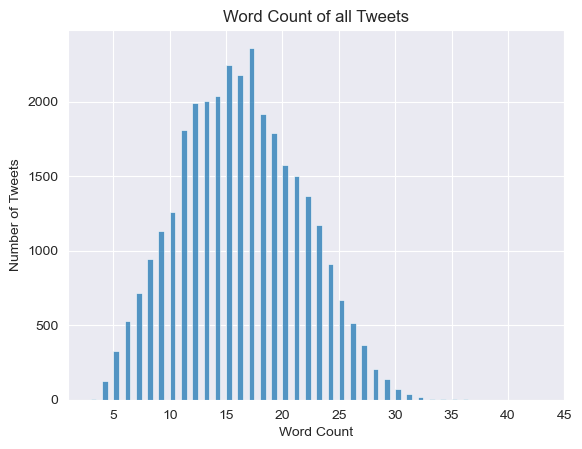

<Figure size 400x200 with 0 Axes>

In [27]:
df_raw = word_count(df_raw)

sns.histplot(df_raw['count_of_words'])

plt.title('Word Count of all Tweets')

plt.xlabel('Word Count')
plt.ylabel('Number of Tweets')
plt.figure(figsize=(4, 2))
plt.show()

### 1.3 Ausreißerprüfung

In [28]:
def find_outlier(data):
    for num_col in data.select_dtypes(["number"]).columns:
        sd = data[num_col].std()
        mean = data[num_col].mean()
        result = [out for out in data[num_col] if (out > mean + 3 * sd) or (out < mean - 3 * sd)]
        print()
        print("Column: ", num_col)
        print("Mean: ", mean, "; Std: ", sd)
        print("Outlier: ", len(result), "; Values: ", sorted(result))

In [29]:
find_outlier(df_raw[['count_of_words']])


Column:  count_of_words
Mean:  16.048182216381953 ; Std:  5.395800656851026
Outlier:  24 ; Values:  [33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 38, 39, 40, 42, 43]


## 2. Datenvorbereitung

In [30]:
df_clean_base = df_origin.copy()

### 2.1 Datenbereinigung allgemein

#### Duplikate

In [31]:
df_clean_base.duplicated().sum()

2432

In [32]:
df_clean_base.drop_duplicates(inplace=True)
df_clean_base.duplicated().sum()

0

#### Ausreißer

In [33]:
# todo klären

#### Encoding

In [34]:
df_clean_base["tweet"] = df_clean_base['tweet'].apply(fix_encoding)

In [35]:
df_clean_base

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦
5,0,factsguide: society now #motivation
...,...,...
31957,0,off fishing tomorrow @user carnt wait first time in 2 years
31958,0,ate @user isz that youuu?😍😍😍😍😍😍😍😍😍❤️
31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher


### 2.1 Datenbereinigung speziell für Textverarbeitung

##### 2.1.1 Entfernung von special characters

In [36]:
def remove_special_characters(df):
    pattern = re.compile(r'<.*?>|@\w+|[\/§&]')
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(lambda x: pattern.sub('', x))
    return df

##### 2.1.2 Entfernung von URL's im Text

In [37]:
def remove_url_from_tweet(df):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(lambda x: pattern.sub('', x))
    return df

##### 2.1.3 Entfernung von Punkten, Kommas

In [38]:
def remove_punctuation(df):
    pattern = re.compile(r'[.:?!,\[\]/%&§{}]')
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(lambda x: pattern.sub('', x))
    return df

##### 2.1.4 Entfernung von Nummern

In [39]:
def remove_digis(df):
    pattern = re.compile(r'\d')
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(lambda x: pattern.sub('', x))
    return df

##### 2.1.5 Extraktion/Korrektur von shortcuts/slangs im Text

In [40]:
def expand_shortforms(text):
    text = re.sub("isn't", 'is not', text)
    text = re.sub("he's", 'he is', text)
    text = re.sub("wasn't", 'was not', text)
    text = re.sub("there's", 'there is', text)
    text = re.sub("couldn't", 'could not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("they're", 'they are', text)
    text = re.sub("she's", 'she is', text)
    text = re.sub("There's", 'there is', text)
    text = re.sub("wouldn't", 'would not', text)
    text = re.sub("haven't", 'have not', text)
    text = re.sub("That's", 'That is', text)
    text = re.sub("you've", 'you have', text)
    text = re.sub("He's", 'He is', text)
    text = re.sub("what's", 'what is', text)
    text = re.sub("weren't", 'were not', text)
    text = re.sub("we're", 'we are', text)
    text = re.sub("hasn't", 'has not', text)
    text = re.sub("you'd", 'you would', text)
    text = re.sub("shouldn't", 'should not', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("they've", 'they have', text)
    text = re.sub("You'll", 'You will', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub("we've", 'we have', text)
    text = re.sub("it's", 'it is', text)
    text = re.sub("don't", 'do not', text)
    text = re.sub("that´s", 'that is', text)
    text = re.sub("I´m", 'I am', text)
    text = re.sub("it’s", 'it is', text)
    text = re.sub("she´s", 'she is', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('I’m', 'I am', text)
    text = re.sub('I’d', 'I did', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('there’s', 'there is', text)

    return text


def expand_slang(text):
    new_text = []
    for w in text.split():

        if w.upper() in shortcuts:
            new_text.append(shortcuts[w.upper()])  # Ersetzen, wenn es ein Shortcut ist
        # if w in shortcuts:
        #     new_text.append(shortcuts[w])
        else:
            new_text.append(w)  # sonst original beibehalten

    return ' '.join(new_text)


def expand_shortcuts(df):
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(expand_slang)
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(expand_shortforms)
    return df

##### 2.1.6 Entfernung von Stopwords

In [41]:
def remove_stop_words(df):
    stop_words = set(stopwords.words('english'))

    df['tweet_cleaned'] = df['tweet_cleaned'].apply(
        lambda x: " ".join(w for w in x.split() if w.lower() not in stop_words))
    return df

##### 2.1.6  Korrektur von Großbuchstaben in Wörtern

In [42]:
def to_lowercase_if_string(text):
    if isinstance(text, str):
        return text.lower()
    return text


def to_lowercase(df):
    df['tweet_cleaned'] = df['tweet_cleaned'].fillna('').apply(to_lowercase_if_string)
    return df


##### 2.1.7  Korrektur von falsch geschriebenen Wörtern im Text

In [43]:
def correct_misspelled_words_in_sentence(text):
    words = text.split()
    corrected_text = []

    for word in words:
        text_blob = TextBlob(word)
        corrected_text.append(str(text_blob.correct()))

    return ' '.join(corrected_text)


def clean_misspelled_words(df):
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(correct_misspelled_words_in_sentence)
    return df


In [44]:
df_cleaned_1 = df_raw.iloc[0:100].copy()
start = time.time()
df_cleaned_1['tweet_corrected'] = df_cleaned_1['tweet'].apply(correct_misspelled_words_in_sentence)
end = time.time()
print("Elapsed time: ", end - start)

Elapsed time:  74.29399752616882


In [45]:
df_cleaned_1[["tweet", "tweet_corrected"]].head(100)

,tweet,tweet_corrected
id,,
1,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kiss into his dysfunction. #run
2,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #left credit i can't use cause they don't offer wheelchair van in pox. #disappointed #getthanked
3,bihday your majesty,midday your majesty
4,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in or±!!! ðððð ð¦ð¦ð¦
5,factsguide: society now #motivation,factsguide: society now #motivation
...,...,...
96,"@user i'll always hope that one day i'll get to hug you, but i don't think that it's gonna happen anytime soon...","@user i'll always hope that one day i'll get to hug you, but i don't think that it's donna happen daytime soon..."
97,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in or±!!! ðððð ð¦ð¦ð¦
98,couple having sex fat naked japanese girls,couple having sex fat naked japanese girls


##### 2.1.8 Ersetzen von Emojis

In [46]:
def replace_emoji_in_sentence(text):
    if isinstance(text, str):
        new_text = emoji.demojize(text, delimiters=("__", "__"))
        return new_text.replace("__", " ")
    else:
        return text


def replace_emojis(df):
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(replace_emoji_in_sentence)
    return df

##### 2.1.9  Entfernung von Emojis

In [47]:
def remove_emoji_in_sentence(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols, pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"  # other symbols
                               u"\U00002FC2-\U0001F251"  # more symbols
                               "]+", flags=re.UNICODE)

    if isinstance(text, str):
        return emoji_pattern.sub(r'', text)
    return text


def remove_emojis(df):
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(remove_emoji_in_sentence)
    return df


In [48]:
def get_emojis(text):
    emoji_list = []
    for word in text.split():
        for char in word:
            if emoji.is_emoji(char):
                emoji_list.append(emoji.demojize(char))
    return ','.join(emoji_list)


def extract_emojis(df):
    df['emojis'] = df['tweet_cleaned'].apply(get_emojis)
    return df

 ##### 2.1.10 Umgang mit Hashtags

In [49]:
# todo im Gruppenrahmen klären
def remove_hashtags_from_tweet(text):
    new_text = []
    for word in text.split():
        if not word.startswith('#'):
            new_text.append(word)
    return ' '.join(new_text)


def handle_hashtags(df):
    df['hashtags'] = [re.findall(r'#\w+', x) if re.findall(r'#\w+', x) else [] for x in df.tweet]
    df['tweet_cleaned'] = df['tweet_cleaned'].apply(remove_hashtags_from_tweet)
    return df

##### 2.1.11 Umgang mit User-Handles

In [50]:
# todo im Gruppenrahmen klären
def handle_userhandles(df):
    df['user_handle'] = df['tweet_cleaned'].str.count('@user')
    df['tweet_cleaned'] = df['tweet_cleaned'].str.replace('@user', '', case=False)
    return df

##### 2.1.12 Auflösen von Negationen

In [51]:
# todo im Gruppenrahmen klären
def remove_negations(df):
    return df

##### 2.1.13 Entfernung Most frequent Words

In [52]:
def create_word_counter(col):
    cnt = Counter()
    for text in col.values:
        for word in text.split():
            cnt[word] += 1

    return cnt


def remove_freqwords(text, freqwords):
    return " ".join([word for word in str(text).split() if word not in freqwords])


def remove_most_frequent_words(df):
    counter = create_word_counter(df["tweet_cleaned"])
    freqwords = set([w for (w, wc) in counter.most_common(10)])
    df['tweet_cleaned'] = df["tweet_cleaned"].apply(lambda text: remove_freqwords(text, freqwords))
    return df

##### 2.1.15 Stemming

Vergleich unterschiedlicher Stemmer, Vergleich Stemming mit Lemmatization

In [77]:
porter = PorterStemmer()
snow = SnowballStemmer("english")
word_net = WordNetLemmatizer()


def find_words(col):
    cnt = Counter()
    for text in col.values:
        for word in text.split():
            word = re.sub('[^A-Za-z]+', '', word)
            if len(word) == 7:
                cnt[word] += 1

    return cnt


counter = find_words(df_clean_base["tweet"])
words = set([w for (w, wc) in counter.most_common(100)])

In [97]:
df_stem = pd.DataFrame(
    columns=["not_stemmed", "porter_stemmed", "snowball_stemmed", "word_net_lemmatized", "textblob_lemmatized"])

for word in words:
    stemmed_word_porter = porter.stem(word)
    stemmed_word_snow = snow.stem(word)
    lemmatized = word_net.lemmatize(word)
    blob_lemmatizer = Word(word).lemmatize()

    df_stem.loc[-1] = [word, stemmed_word_porter, stemmed_word_snow, lemmatized, blob_lemmatizer]
    df_stem.index = df_stem.index + 1
    df_stem = df_stem.sort_index()

df_stem

,not_stemmed,porter_stemmed,snowball_stemmed,word_net_lemmatized,textblob_lemmatized
0,friends,friend,friend,friend,friend
1,flowers,flower,flower,flower,flower
2,looking,look,look,looking,looking
3,thought,thought,thought,thought,thought
4,waiting,wait,wait,waiting,waiting
...,...,...,...,...,...
195,friends,friend,friend,friend,friend
196,friends,friend,friend,friend,friend
197,friends,friend,friend,friend,friend
198,friends,friend,friend,friend,friend


Problem Stemming: Entfernung von zu viel Inhalt
Problem Lemmatization: aktuell zu simpel, kein Part-of-Speech Tagging

##### 2.1.15 Lemmatization
https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

In [135]:
nlp = spacy.load("en_core_web_sm")


def spacy_lemmatize(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token)

    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
    return lemmatized_sentence

In [136]:
def lemmatize(df):
    df["tweet_cleaned"] = df['tweet_cleaned'].apply(lambda text: spacy_lemmatize(text))
    return df

##### 2.1.16 Entfernung rare words

In [150]:
min_threshold = 3

In [189]:
def create_word_counter(col):
    cnt = Counter()
    for text in col.values:
        for word in text.split():
            cnt[word] += 1

    return cnt


def remove_least_freqwords(text, least_freqwords):
    return " ".join([word for word in str(text).split() if word not in least_freqwords])


def remove_least_frequent_words(df):
    counter = create_word_counter(df["tweet_cleaned"])
    filtered_counter = counter.copy()
    for k, v in counter.items():
        if v > min_threshold:
            filtered_counter.pop(k)
    least_freqwords = set([w for (w, wc) in filtered_counter.items()])
    df['tweet_cleaned'] = df["tweet_cleaned"].apply(lambda text: remove_least_freqwords(text, least_freqwords))
    return df

##### 2.1.19 Duplikatentfernung

In [137]:
def remove_duplicates(df):
    df = df.drop_duplicates(subset=['tweet_cleaned'])
    return df

##### 2.1.20 Reihenfolge Datenbereinigung

Sinnvolle Reihenfolge für die Ausführung der einzelnen Bereinigungsschritte
1. Groß-/Kleinschreibung normalisieren
2. Abkürzungen/Slang auflösen
3. Falsch geschriebene Wörter korrigieren
4. Negationen auflösen (falls möglich)
5. Umgang mit User-Handles
6. Umgang mit Hashtags
7. Unnötige Zeichen entfernen
    a. Links
    b. html tags
    d. Punktuation
    e. Sonderzeichen
    f. Zeilenumbrüche
    g. Zahlen
8. Emojis konvertieren (durch Sonderzeichenentfernung muss Umwandlung von Emojis danach geschehen)
    a. Entscheidung: Emojis entfernen?
9. Stemming / Lemmatization
10. Stopwords entfernen
11. Most frequent words entfernen
12. Rare words entfernen
13. Nochmal Duplikate prüfen & entfernen

df_cleaned = find_stop_words(df_cleaned)
df_cleaned = find_hash_tags(df_cleaned)
df_cleaned = find_html_tags(df_cleaned)
df_cleaned = find_urls(df_cleaned)
df_cleaned = find_shortcuts(df_cleaned)
df_cleaned = find_emojis(df_cleaned)
df_cleaned = find_misspelled_words(df_cleaned)
df_cleaned = word_count(df_cleaned)

In [190]:
df_cleaned = df_clean_base.copy()
df_cleaned['tweet_cleaned'] = df_cleaned['tweet']
df_cleaned.head()

,label,tweet,tweet_cleaned
id,,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty,bihday your majesty
4,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦
5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [191]:
df_cleaned = to_lowercase(df_cleaned)
df_cleaned = expand_shortcuts(df_cleaned)

In [192]:
df_cleaned = remove_negations(df_cleaned)
df_cleaned = handle_userhandles(df_cleaned)
df_cleaned = handle_hashtags(df_cleaned)
df_cleaned = remove_url_from_tweet(df_cleaned)
df_cleaned = remove_punctuation(df_cleaned)
df_cleaned = remove_special_characters(df_cleaned)
df_cleaned = remove_digis(df_cleaned)

In [193]:
df_cleaned = extract_emojis(df_cleaned)
# df_cleaned = replace_emojis(df_cleaned)
df_cleaned = remove_emojis(df_cleaned)

In [194]:
# df_cleaned = clean_misspelled_words(df_cleaned) # todo klären

In [195]:
df_cleaned = lemmatize(df_cleaned)

In [196]:
df_cleaned = remove_stop_words(df_cleaned)
df_cleaned = remove_most_frequent_words(df_cleaned)
df_cleaned = remove_least_frequent_words(df_cleaned)
df_cleaned = remove_duplicates(df_cleaned)

In [197]:
df_cleaned.head()

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
id,,,,,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father selfish drag kid,1,[#run],
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank credit use cause offer van,2,"[#lyft, #disapointed, #getthanked]",
3,0,bihday your majesty,bihday majesty,0,[],
4,0,#model i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦,love take time,0,[#model],":mobile_phone:,:kissing_face_with_smiling_eyes:,:smiling_face_with_sunglasses:,:mouth:,:tongue:,:sweat_droplets:,:sweat_droplets:,:sweat_droplets:"
5,0,factsguide: society now #motivation,factsguide society,0,[#motivation],


##### 2.2 Vergleich Datensatz raw-cleaned

In [198]:
print(df_origin.tweet.count())
print(df_cleaned.tweet.count())
print(df_cleaned.tweet.count() - df_origin.tweet.count())
print((df_cleaned.tweet.count() / df_origin.tweet.count() - 1) * 100)

31962
25226
-6736
-21.07502659408047


### Die Ergebnisse speichern

In [149]:
filepath_name = os.path.abspath(os.path.join(current_dir, 'data/train_cleaned.csv'))
directory_path = Path(filepath_name).parent
directory_path.mkdir(parents=True, exist_ok=True)
df_cleaned.to_csv(filepath_name)